<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [6]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Motivation

Hospital readmission after an admitted patient is discharged is a high priority for hospitals. In total Hospital Readmissions are one of the most costly episodes to treat, costing Medicare about 26 billion annually, with about 17 billion consisting of avoidable trips after discharge. 

The health care burden of hospitalized patients with diabetes (1 and 2) is substantial and only growing. As of today, around 9% of Americans have diabetes or prediabetes, according to a recent CDC report. 

A better understanding of the factors that lead to hospital readmissions could help decision makers understand potential ways to reduce early readmissions (within 30 days) and provide more efficient care.

## Data Sources

- Diabetes patients records from 130 hospitals for visits occuring in 1998-2008 (10 years). Data was obtained from UCI Machine Learning DB: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

- ICD-9 Codes diagnosis codes were scraped from: http://www.icd9data.com/2008/Volume1/default.htm

## Classification problem

**We focused our project on attempting to predict whether a discharged diabetic patient will be readmitted into a hospital within 30 days (Target = 1)  or not (Target = 0).**

In [160]:
# Import necessary packages

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
np.random.seed(0)

# need to specify this to prevent kernel from dying when working with XGboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Reading data and Mapping Source codes

In [6]:
df = pd.read_csv('diabetic_data.csv')

In [7]:
df.shape

(101766, 50)

At first, it seems like there are no null values. In reality, there is unavailable information which is represented by a question mark('?') in the dataframe.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

## Mapping Admission, Discharge & Admission Source Types

A separate .csv file contains mapping codes to their description. The file contains all mapping codes, including:
- admission type codes
- discharge type codes
- admission source codes

In [9]:
# importing mapping.csv
mapping = pd.read_csv('IDs_mapping.csv')

In [10]:
#Separating codes by type

admission_type_map = mapping[:8]
discharge_type_map = mapping[10:40]
admission_source_map = mapping[42:]

#Renaming columns
discharge_type_map.columns = ['discharge_disposition_id','description']
admission_source_map.columns = ['admission_source_id', 'description']

In [11]:
discharge_type_map.head(2)

,discharge_disposition_id,description
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...


# EDA & Feature engineering

Removing discharge codes 11 (Expired), 13-14 (Hospice care), 19-21 (Expired) as they consider the patient is terminally ill and the probability of being readmitted is equal to 0. 

In [12]:
# Removing discharge codes 11 (Expired), 13-14 (Hospice care), 19-21 (Expired)
terminally_ill = [11,13,14,19,21]
df = df[~df['discharge_disposition_id'].isin(terminally_ill)]

In [13]:
# Removing NaN & Not mapped values
df = df[~df['admission_type_id'].isin([6,8])]
df = df[~df['admission_source_id'].isin([17,20])]
df = df[~df['discharge_disposition_id'].isin([25])]

In [14]:
# Replacing values into 0 for no change and 1 for change 

df.change = df.change.replace(to_replace = 'Ch', value = 1)
df.change = df.change.replace(to_replace = 'No', value = 0)
df.gender = df.gender.replace(to_replace = 'Female', value = 1)
df.gender = df.gender.replace(to_replace = 'Male', value = 0)

#change our diabetes values 
dm = {'Yes': 1, 'No': 0}
df['diabetesMed'] = df['diabetesMed'].replace(to_replace = (dm), value=None)

It's important to note that the same patients appear several times as they can be admitted more than once. We decide to treat each patient's visit independently and not consider information regarding earlier visits as additional information.

In [15]:
# Identifying duplicate patients

duplicates = df[df.patient_nbr.isin(df.patient_nbr[df.patient_nbr.duplicated()])].sort_values(by = 'patient_nbr')
duplicates[['patient_nbr', 'number_inpatient', 'readmitted']].head()

,patient_nbr,number_inpatient,readmitted
4780,135,1,>30
4267,135,0,<30
23623,1152,1,>30
24642,1152,2,NO
14180,1152,1,>30


For some patients' visits, gender is unknown or invalid and their corresponding rows will be removed as there are only 3 in total.

In [16]:
# Dropping rows where gender is unavailable
df.drop(df[df.gender == 'Unknown/Invalid'].index, inplace=True)

In [17]:
# Number of repeated visits for patients
(df.patient_nbr.value_counts() > 1).sum()

14921

Some columns do not contain useful information regarding a patients' health and are dropped from our data:

- Patient_nbr: contains patient identification number
- Payer_code: contains insurance information

In [18]:
# Dropping identification columns
df.drop('patient_nbr', axis = 1, inplace= True) # Dropping identification column
df.drop('payer_code', axis = 1, inplace= True) # Dropping Insurance information

In [19]:
# Exploring medication values to drop columns containing no information based on value counts
medication = ['max_glu_serum', 'A1Cresult','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

meds_df = df[medication].apply(pd.Series.value_counts)
meds_df

,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
>200,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>300,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>7,NaN,3564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>8,NaN,7463.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Down,NaN,NaN,526.0,42.0,10.0,1.0,179.0,NaN,483.0,494.0,...,NaN,NaN,NaN,NaN,10750.0,6.0,NaN,NaN,NaN,NaN
No,NaN,NaN,71756.0,88523.0,89310.0,89907.0,85174.0,89980.0,78807.0,80524.0,...,89979.0,89952.0,89981.0,89981.0,41606.0,89291.0,89968.0,89980.0,89979.0,89980.0
None,89668.0,74238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Norm,46.0,4716.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Steady,NaN,NaN,16737.0,1312.0,639.0,67.0,4328.0,1.0,10028.0,8241.0,...,2.0,28.0,NaN,NaN,27515.0,677.0,13.0,1.0,2.0,1.0
Up,NaN,NaN,962.0,104.0,22.0,6.0,300.0,NaN,663.0,722.0,...,NaN,1.0,NaN,NaN,10110.0,7.0,NaN,NaN,NaN,NaN


In [20]:
# Dropping encounter_id & medication with less than 2 varying values
df.drop(['encounter_id','metformin-pioglitazone','metformin-rosiglitazone',
         'glimepiride-pioglitazone','troglitazone','acetohexamide','examide','citoglipton'], axis =1, inplace= True)

Many columns contain '?', None as an answer. For the following columns, they will be replaced by an appropriate value:

- For weight, race, medical_specialty, value will be replaced by "Not specified".
- For max_glu_serum, A1Cresult, value should be interpreted as "Not Measured", according to https://www.hindawi.com/journals/bmri/2014/781670/tab1/

In [21]:
# Replacing '?' Values into appropriate values

df.weight = df.weight.replace(to_replace='?', value='Not specified') # Not specified for Weight
df.race = df.race.replace(to_replace='?', value='Not Specified') # 'Not specified for Race
df.medical_specialty = df.medical_specialty.replace(to_replace='?', value='Not specified') # 'Not specified' for Med.Specialty
df.max_glu_serum = df.max_glu_serum.replace(to_replace='None', value = 'Not measured') # According to https://www.hindawi.com/journals/bmri/2014/781670/tab1/
df.max_glu_serum = df.max_glu_serum.replace(to_replace='Norm', value = 'Normal') # To make it more readable
df.A1Cresult = df.A1Cresult.replace(to_replace='None', value = 'Not measured') # According to https://www.hindawi.com/journals/bmri/2014/781670/tab1/
df.A1Cresult = df.A1Cresult.replace(to_replace='Norm', value = 'Normal') # To make it more readable

## Target Variable: Setting Early (within 30 days) readmission to '1' 

In [22]:
# First, checking for NA values in target variable
df.readmitted.isna().sum() 

0

>We are trying to predict patient early readmissions (within 30 days), therefore we combine readmissions over 30 days in the same group as non readmitted patients. In this case, we have a binary classification problem and logistic regression can be used as a base model.

In [23]:
# Combining > 30 days before readmission and No as one category
df.readmitted = df.readmitted.replace(to_replace='>30', value='0')
df.readmitted = df.readmitted.replace(to_replace='NO', value='0')
df.readmitted = df.readmitted.replace(to_replace='<30', value='1')

In [24]:
# Changing Object type columns to int because values are 0 or 1
df.readmitted = df.readmitted.astype(int)
df.gender = df.gender.astype(int)

## Class Imbalance: Target variable

> The target variable identifying whether a patient was readmitted early (within 30 days) is imbalanced, 11% of patients were readmitted within 30 days.
To combat imbalanced data, we opted to **downsample** the 'No' category. This will allow us to achieve a balance ratio closer to 1:1 and improve our binary classification predictions.

In [25]:
# Checking for class imbalance
df.readmitted.value_counts(normalize = True)

0    0.88592
1    0.11408
Name: readmitted, dtype: float64

##  Webscraping ICD-9 Codes & their descriptions

> In health care, diagnosis codes are used as a tool to group and identify diseases, disorders, symptoms, poisonings, adverse effects of drugs and chemicals, injuries and other reasons for patient encounters. Diagnostic coding is the translation of written descriptions of diseases, illnesses and injuries into codes from a particular classification. In medical classification, diagnosis codes are used as part of the clinical coding process alongside intervention codes. International Statistical Classification of Diseases and Related Health Problems (ICD) is one of the most widely used classification systems for diagnosis coding as it allows comparability and use of mortality and morbidity data.

>ICD codes in this dataset refer to ICD-9 codes.


In [26]:
# Page to scrape
page = f'http://www.icd9data.com/2008/Volume1/default.htm'

# Make a get request to retrieve the page
html_page = requests.get(page)

# Pass the page content to beautiful soup for parsing
soup = BeautifulSoup(html_page.content, 'html.parser') 
pretty_soup = soup.prettify()

# Beautiful soup to retrieve ICD codes & description
icd9 = [li.text.split('  ') for li in soup.find('ul').find_all('li')]

# Converting diagnosis codes into dataframe
icd9_df = pd.DataFrame(icd9, columns = ['icd9_range', 'diagnosis_desc'])

# Creating a range of values for icd9 codes
icd9_df['icd9_range'] = list(icd9_df['icd9_range'].apply(lambda x: x.split('-')))

icd9_df

,icd9_range,diagnosis_desc
0,"[001, 139]",Infectious And Parasitic Diseases
1,"[140, 239]",Neoplasms
2,"[240, 279]","Endocrine, Nutritional And Metabolic Diseases,..."
3,"[280, 289]",Diseases Of The Blood And Blood-Forming Organs
4,"[290, 319]",Mental Disorders
5,"[320, 389]",Diseases Of The Nervous System And Sense Organs
6,"[390, 459]",Diseases Of The Circulatory System
7,"[460, 519]",Diseases Of The Respiratory System
8,"[520, 579]",Diseases Of The Digestive System
9,"[580, 629]",Diseases Of The Genitourinary System


## Mapping diagnosis codes to grouped ICD-9 codes

In [27]:
# Function to map diagnosis codes to the description of group disease they belong to

def icd_map(code):
    
    # Special characters mapping
    if str(code)[0] == 'V':
        return icd9_df.diagnosis_desc.loc[17]
    elif str(code)[0] == 'E':
        return icd9_df.diagnosis_desc.loc[18]
    
    # Replacing question mark into No diagnosis
    elif str(code)[0] == '?':
        return 'No diagnosis'
    
    # Numerical codes mapping
    else:
        code = round(float(code),0)
        for i in range(0,19):
            if code in range(int(icd9_df.icd9_range[i][0]),int(icd9_df.icd9_range[i][1])+1):
                return icd9_df.diagnosis_desc[i]

In [28]:
# Feature Engineering - Mapping to ICD9 codes and merging to initial dataframe
df['diag1_desc'] = df['diag_1'].apply(icd_map)
df['diag2_desc'] = df['diag_2'].apply(icd_map)
df['diag3_desc'] = df['diag_3'].apply(icd_map)

In [29]:
# Diagnosis table
diagnosis = df[['diag1_desc','diag2_desc','diag3_desc']].apply(pd.Series.value_counts)
diagnosis

,diag1_desc,diag2_desc,diag3_desc
"Complications Of Pregnancy, Childbirth, And The Puerperium",663,409,292
Congential Anomalies,43,95,87
Diseases Of The Blood And Blood-Forming Organs,1016,2566,2202
Diseases Of The Circulatory System,26911,27728,26549
Diseases Of The Digestive System,8130,3478,3142
Diseases Of The Genitourinary System,4564,7169,5592
Diseases Of The Musculoskeletal System And Connective Tissue,4417,1603,1716
Diseases Of The Nervous System And Sense Organs,1100,1157,1562
Diseases Of The Respiratory System,8903,8782,5825
Diseases Of The Skin And Subcutaneous Tissue,2257,3264,2213


In [30]:
# Dropping ICD9 code columns as they are now grouped
df = df.drop(['diag_1','diag_2','diag_3'],axis =1)

In [31]:
df.shape

(89981, 40)

## Grouping drugs by drug class

>To reduce dimensionality, we grouped 16 medications into 6 drug families.

> biguanides : The term biguanide refers to a group of oral type 2 diabetes drugs that work by preventing the production of glucose in the liver, improving the body's sensitivity towards insulin and reducing the amount of sugar absorbed by the intestines.

> meglitinides : The glinides are a class of drug which have a similar response as sulphonylureas but act for a shorter time. Meglitinides are prescribed to be taken by people with type 2 diabetes within half an hour before eating. As the drugs act for a shorter period than sulphonylureas, the side effects of hypoglycemia and weight gain have a smaller likelihood.

> sulfonylureas : Sulphonylureas are the class of antidiabetic drug for type 2 diabetes that tends to include those drugs which end in ‘ide’. They work by increasing the amount of insulin the pancreas produces and increasing the working effectiveness of insulin. The mode of action of sulphonylureas means that hypoglycemia and weight gain can be relatively common side effects.

> thiazolidinediones : Thiazolidinediones, also known as glitazones, are a medication for type 2 diabetes which help to improve insulin sensitivity and have been found to help decrease triglyceride levels.

> alpha_glucosidase_inhibitors : Alpha-glucosidase inhibitors, such as acarbose (marketed as Precose or Glucobay) or miglitol (branded as Glyset) are drugs for type 2 diabetes which slow down the digestion of carbohydrates in the small intestine and therefore can help to reduce after meal blood sugar levels.

> insulins : Insulin is a hormone which helps to regulate blood sugar. A number of different types of insulin are available as medication, with some insulins acting for as long as a day and others acting for only a few hours.

source : https://www.diabetes.co.uk/diabetes-medication/

We have also classified our patients as either "on" or "off" each medication, by changing the values 'Down, Up, Steady' to True and values 'No' to False.

In [39]:
# create a dictionary with the different medication families for each diabetes drug so that
# we can manipulate these columns and narrow down the amount of features we are using
drug_classes = {'biguanides' : ['metformin', 'glyburide-metformin', 'glipizide-metformin'], 
                'meglitinides':['repaglinide','nateglinide'], 
                'sulfonylureas': ['chlorpropamide','glimepiride','glipizide', 'glyburide','tolbutamide', 'tolazamide','glyburide-metformin', 'glipizide-metformin'], 
                'thiazolidinediones': ['pioglitazone','rosiglitazone'], 
                'alpha_glucosidase_inhibitors': ['acarbose', 'miglitol'], 
                'insulins': ['insulin']}

#Create dictionary with our keys as the data found in our medication columns and the values of each key as a Bool  
replaced = {'Steady': True, 'Up': True, 'Down': True, 'No': False} 


#Iterate through and classify our patients as either on or off each medication, by changing our values for 'Down, Up, Steady' to True and our value for 'No' as False
for column in df.iloc[:,18:34]:
    df[column] = df[column].replace(to_replace = replaced, value = None)

Moreover, we created new variable columns for each drug class family and indicated whether a patient takes any medication within each family of drugs.

In [45]:
# need to create new dummy variable column for each drug class family and 
# have it equal true if the individual is on a medication for any drug within that family

df['biguanides'] = df[(df['metformin'] == True) | (df['glyburide-metformin'] == True) | (df['glipizide-metformin'] == True)].any(axis=1)
df['biguanides'] = df['biguanides'].fillna(False) 


# create a conditional statement
df['meglitinides'] = df[(df['repaglinide'] == True) | (df['nateglinide'] == True)].any(axis=1)
df['meglitinides'] = df['meglitinides'].fillna(False) 


df['sulfonylureas'] = df[(df['chlorpropamide'] == True) | (df['glimepiride'] == True) | (df['glipizide']==True) | (df['glyburide'] == True) | (df['tolbutamide'] == True) | (df['tolazamide'] == True) | (df['glyburide-metformin'] == True) | (df['glipizide-metformin'] == True)].any(axis=1) 
df['sulfonylureas'] = df['sulfonylureas'].fillna(False)                                                            
                                            

df['thiazolidinediones'] = df[(df['pioglitazone'] == True) | (df['rosiglitazone'] == True) | (df['glipizide'] == True)].any(axis=1)
df['thiazolidinediones'] = df['thiazolidinediones'].fillna(False)     


df['alpha_glucosidase_inhibitors'] = df[(df['acarbose'] == True) | (df['miglitol'] == True)].any(axis=1)
df['alpha_glucosidase_inhibitors'] = df['alpha_glucosidase_inhibitors'].fillna(False)


df['insulins'] = df[(df['insulin'] == True)].any(axis=1) 
df['insulins'] = df['insulins'].fillna(False)  


df = df.drop(df.iloc[:,18:34], axis =1)

## Medical specialties: Retaining 10 medical specialties

> To reduce dimensionality of medical specialties, we have grouped all the medical specialties who had less than 500 patients into one category called "Other".

In [47]:
# Identifying Top 10 medical specialties, will group all other specialties into 'Other' category
df.medical_specialty.value_counts() > 500

Not specified                            True
InternalMedicine                         True
Emergency/Trauma                         True
Family/GeneralPractice                   True
Cardiology                               True
Surgery-General                          True
Orthopedics                              True
Nephrology                               True
Radiologist                              True
Orthopedics-Reconstructive               True
Psychiatry                               True
Pulmonology                              True
Surgery-Cardiovascular/Thoracic          True
ObstetricsandGynecology                  True
Urology                                  True
Surgery-Vascular                        False
Gastroenterology                        False
Surgery-Neuro                           False
PhysicalMedicineandRehabilitation       False
Oncology                                False
Pediatrics                              False
Neurology                         

In [48]:
#create a list for our top 10 professions which will allow us to group all of our other values into "Other" 
medprofessions = ['Not specified', 'InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Nephrology', 'Radiologist', 'Orthopedics-Reconstructive']


#replace all values in medical_specialty column that are not considered the most common with the value 'Other'
df.loc[~df.medical_specialty.isin(medprofessions), 'medical_specialty'] = 'Other'

## Correlation Heatmap

> There is a -0.75 correlation between admission source id and admission type id. There is no correlation over |0.8| between numerical variables, therefore they will all be included in the initial model as regressors.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text yticklabel objects>)

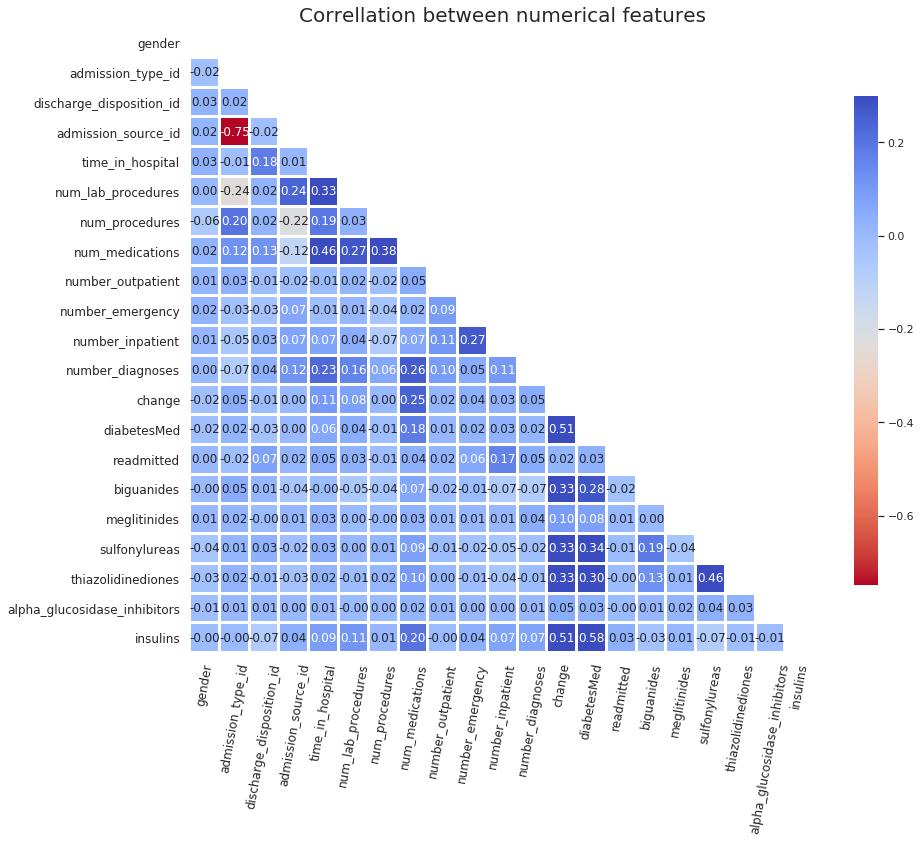

In [49]:
# Correlation heatmap
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

plt.figure(figsize=(14,12))

sns.heatmap(df.corr(),mask=mask, annot= True, vmax=.3,cmap = 'coolwarm_r', square=True, fmt='.2f',
            linewidths=2, cbar_kws={"shrink": 0.75})
plt.title('Correllation between numerical features', size = 20)
plt.xticks(rotation=80, size = 12)
plt.yticks(size = 12)

## Combining 3 diagnosis codes into separate indicator dummy variables

> Each patient has 3 different diagnosis (diag1_desc, diag2_desc, diag3_desc). We decided to create dummy variables to indicate whether a patient had a diagnosis or not (True or False). To do so, we created a function to identify which diseases were present for each patient by encoding each of disease as a dummy variable.

In [55]:
def make_col_diagnosis(diagnosis):
    df[diagnosis] = df[(df['diag1_desc'] == diagnosis) | (df['diag2_desc'] == diagnosis)
                       | (df['diag3_desc'] == diagnosis)].any(axis=1)
    df[diagnosis] = df[diagnosis].fillna(False)

In [56]:
for diag in diagnosis.T.columns.tolist():
    make_col_diagnosis(diag)

In [57]:
df = df.drop(['diag1_desc','diag2_desc','diag3_desc'], axis = 1)

In [58]:
df = df.reset_index()
df = df.drop('index', axis =1) 

## Exploring distribution of age 

In [59]:
age_dict = df.age.value_counts().to_dict()
age_dict = collections.OrderedDict(sorted(age_dict.items()))
age_dict

OrderedDict([('[0-10)', 146),
             ('[10-20)', 640),
             ('[20-30)', 1526),
             ('[30-40)', 3415),
             ('[40-50)', 8697),
             ('[50-60)', 15550),
             ('[60-70)', 20157),
             ('[70-80)', 22689),
             ('[80-90)', 14822),
             ('[90-100)', 2339)])

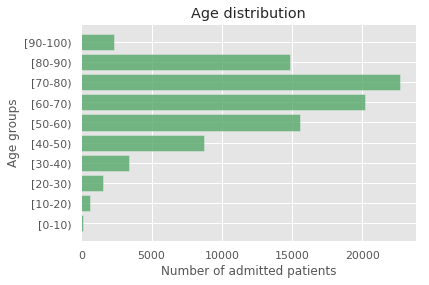

<Figure size 864x576 with 0 Axes>

In [60]:
# Horizontal barplot
plt.style.use('ggplot')
plt.barh(np.arange(10), list(age_dict.values()), align='center', alpha=0.8, color = 'g')
plt.yticks(np.arange(10), age_dict.keys())
plt.xlabel('Number of admitted patients')
plt.ylabel('Age groups')
plt.title('Age distribution')
plt.figure(figsize=(12,8))
plt.show()

## Exploring distribution of numerical variables

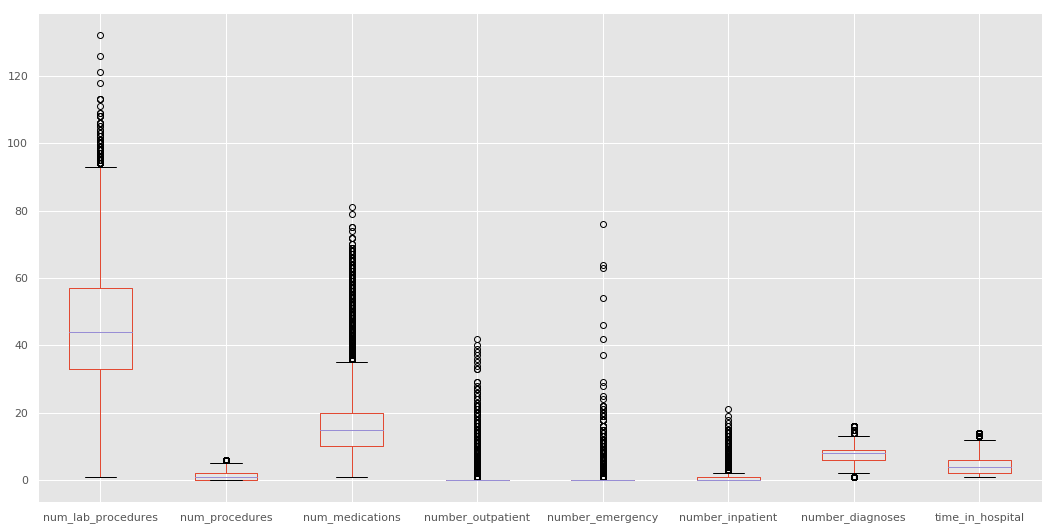

In [64]:
df[['num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses','time_in_hospital']].boxplot(figsize = (18,9))

In [65]:
#Creating a deep copy
df1 = df.copy(deep=True)

# Part 2: Dimensionality reduction with PCA limited to 6 components

To reduce dimensionality, we have opted for an observed variance ratio cutoff at 0.075 meaning that each component should explain at least .075 of the total variance in order to be included as a principal component.

In [66]:
X_scale = ['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [67]:
#Standard Scaler to scale our continuous variables 

scaler = StandardScaler()
scaled_for_x = scaler.fit(df1[X_scale])
x = scaled_for_x.transform(df1[X_scale]) 

#using PCA to reduce dimensionality of our continuous variables 
pca = PCA(n_components = 6)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5','PCA_6'])

#examine the variance explained by our Principal Components
print(pca.explained_variance_ratio_)


[0.25388298 0.17179902 0.12493312 0.11906943 0.10244657 0.09167577]


In [68]:
#add our new PCA columns to our dataframe
df1 = pd.concat([principalDf, df1], axis=1) 
#drop our old continuous variable columns
df1.drop(X_scale, axis = 1, inplace=True)

# Part 3: Preparing data for modeling
## Dummy Variables Encoding for Categorical Data

>  Label encoding for categorical data not changed manually: 'age','race', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'medical_specialty', 'max_glu_serum', 'A1Cresult'

In [69]:
# Creating Dummy variables for all the following categorical columns

X_dummies = ['age','race', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'medical_specialty', 'max_glu_serum', 'A1Cresult']

dummies_1 = pd.get_dummies(df1['age'], prefix = 'age', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_2 = pd.get_dummies(df1['race'],prefix = 'race', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_3 = pd.get_dummies(df1['weight'],prefix = 'weight', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_4 = pd.get_dummies(df1['admission_type_id'],prefix = 'admission_type', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_5 = pd.get_dummies(df1['discharge_disposition_id'],prefix = 'discharge_disposition', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_6 = pd.get_dummies(df1['admission_source_id'],prefix = 'admission_source', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_7 = pd.get_dummies(df1['medical_specialty'],prefix = 'medical_specialty', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_8 = pd.get_dummies(df1['max_glu_serum'],prefix = 'max_glu_serum', drop_first = True).rename(columns=lambda x: '_' + str(x))
dummies_9 = pd.get_dummies(df1['A1Cresult'],prefix = 'A1Cresult', drop_first = True).rename(columns=lambda x: '_' + str(x))

In [70]:
# Adding dummy columns to Dataframe
dummies = [dummies_1,dummies_2,dummies_3,dummies_4,dummies_5,dummies_6,dummies_7,dummies_8,dummies_9]
for dummy in dummies:
    df1 = pd.concat([df1, dummy], axis=1)

In [71]:
# Dropping dummies encoded columns
df1.drop(X_dummies, axis =1, inplace=True)

In [72]:
df1.shape

(89981, 109)

## Setting regressors X & target variable y

In [73]:
y = df1.readmitted
X = df1.drop(['readmitted'], axis = 1)

In [79]:
y.shape

(89981,)

In [80]:
X.shape

(89981, 108)

## Undersampling y & Setting Training sets for X and y

In [81]:
X_resampled, y_resampled = RandomUnderSampler().fit_sample(X,y)

In [82]:
print(y.value_counts()) #Previous original class distribution
X_resampled, y_resampled = RandomUnderSampler().fit_sample(X, y) 
print(pd.Series(y_resampled).value_counts()) #Preview synthetic sample class distribution

0    79716
1    10265
Name: readmitted, dtype: int64
1    10265
0    10265
dtype: int64


In [83]:
#split our data into a test and train set
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = .20) 

## ROC-AUC curve function

In [90]:
def create_roc_auc(model, name):
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    y_score_train = model.predict_proba(X_train)[:,1]
    fpr_t, tpr_t, thresholds_t = roc_curve(y_train, y_score_train)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC_test: {}'.format(auc(fpr, tpr)))
    print('AUC_train: {}'.format(auc(fpr_t, tpr_t)))
    
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='coral',
             lw=lw, label='ROC curve - Test')
    plt.plot(fpr_t, tpr_t, color='deepskyblue',
             lw=lw, label='ROC curve - Train')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

# Part 4: Modeling and Tuning models

## Baseline Model: Logistic Regression

In [91]:
#instantiate logreg object
logreg = LogisticRegression(fit_intercept= False)

#fit our model with our training data
model_log = logreg.fit(X_train, y_train) 

#predict our target variable 
y_train_hat = model_log.predict(X_train)
y_test_hat = model_log.predict(X_test) 

In [92]:
print('accuracy train score:', accuracy_score(y_train, y_train_hat))
print('accuracy test score:', accuracy_score(y_test, y_test_hat))
print('recall score for test:', recall_score(y_test, y_test_hat)) 
print('recall score for train:', recall_score(y_train, y_train_hat))
print('precision score for test:', precision_score(y_test, y_test_hat))
print('precision score for train:', precision_score(y_train, y_train_hat))
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

accuracy train score: 0.6173283000487092
accuracy test score: 0.6161714564052606
recall score for test: 0.5400291120815138
recall score for train: 0.5426621160409556
precision score for test: 0.6392877656519241
precision score for train: 0.6373657838224768


In [93]:
confusion_matrix(y_test, y_test_hat)

array([[1417,  628],
       [ 948, 1113]])

In [94]:
# Residuals
resid = pd.DataFrame(abs(y_train - y_train_hat), columns=['residual'])
resid.residual.value_counts(normalize = True) #  accurate

0    0.617328
1    0.382672
Name: residual, dtype: float64

AUC_test: 0.6605263189113457
AUC_train: 0.6689954220895153


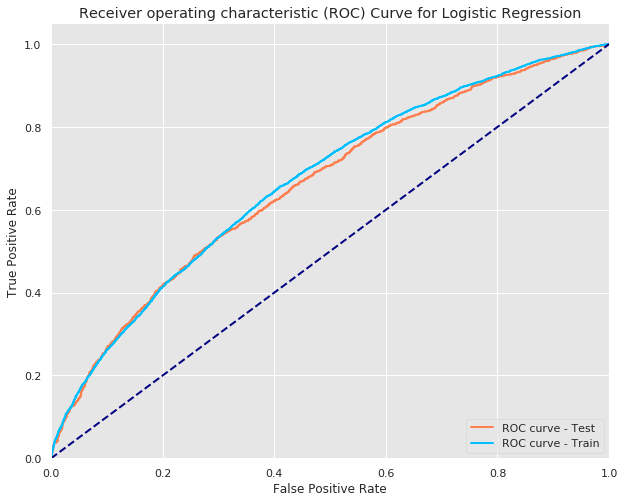

In [96]:
create_roc_auc(model_log, 'Logistic Regression')

### Tuning Logistic Regression

Tuning logistic regression predictions with parameter grid:

> Results are similar to base model, best parameters are mostly the default values. Best parameters C = 1, penalty score based on L1 - Lasso. (default is L2), number of iterations = 100. **Lasso** shrinks some coefficients close to 0 or to 0 by penalizing the cost function.

In [97]:
# Parameter grid

param_grid = {"max_iter" : [100,200,500],
    "penalty": ['l1','l2'],
    "C" : [1,10]}

In [98]:
# Grid search & fitting logistic regression

logreg_cv = LogisticRegression()
dt_grid_search = GridSearchCV(logreg_cv, param_grid = param_grid, cv = 3, return_train_score=True, scoring = 'accuracy')
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_iter': [100, 200, 500], 'penalty': ['l1', 'l2'], 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [99]:
# Best parameters

dt_grid_search.best_params_

{'C': 1, 'max_iter': 100, 'penalty': 'l1'}

In [100]:
#predict our target variable

y_train_hat = dt_grid_search.predict(X_train)
y_test_hat = dt_grid_search.predict(X_test)

In [101]:
print('accuracy train score:', accuracy_score(y_train, y_train_hat))
print('accuracy test score:', accuracy_score(y_test, y_test_hat))
print('recall score for test:', recall_score(y_test, y_test_hat)) 
print('recall score for train:', recall_score(y_train, y_train_hat))
print('precision score for test:', precision_score(y_test, y_test_hat))
print('precision score for train:', precision_score(y_train, y_train_hat))

accuracy train score: 0.6179371651242085
accuracy test score: 0.6144666341938626
recall score for test: 0.5356622998544396
recall score for train: 0.5414431984397855
precision score for test: 0.638150289017341
precision score for train: 0.6386772106398274


In [111]:
print(confusion_matrix(y_test, y_test_hat))

# Classification Report for Training data
class_rep_log = pd.DataFrame(classification_report(y_train, y_train_hat))
class_rep_log

[[1419  626]
 [ 957 1104]]


In [75]:
# Classification Report for Testing data

class_rep_log = pd.DataFrame(classification_report(y_test, y_test_hat, output_dict = True))
class_rep_log

,0,1,micro avg,macro avg,weighted avg
f1-score,0.641936,0.582432,0.614467,0.612184,0.612068
precision,0.597222,0.638150,0.614467,0.617686,0.617766
recall,0.693888,0.535662,0.614467,0.614775,0.614467
support,2045.000000,2061.000000,4106.000000,4106.000000,4106.000000


## KNN:  K-Nearest Neighbors

> Using GridSearch and comparing K = 5 and K = 100, our KNN model is optimized using K = 100. Results are poor and computationally expensive to optimize. KNN is not ideal for the size of our data.

In [113]:
# Fitting KNN with K = 100

param_grid_knn = {'n_neighbors' : [5, 100]}
knn = KNN()
grid_knn = GridSearchCV(knn, param_grid = param_grid_knn)
grid_knn.fit(X_train, y_train)

In [ ]:
# Best K
grid_knn.best_params_

In [116]:
knn_best = KNN(n_neighbors=100)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

In [170]:
#predict our target variable 
y_train_hat = knn_best.predict(X_train)
y_test_hat = knn_best.predict(X_test) 

In [169]:
# Confusion Matrix
print(confusion_matrix(y_test, y_test_hat))

# Classification Report for Training data
class_rep_tr = pd.DataFrame(classification_report(y_train, y_train_hat, output_dict = True))
class_rep_tr

[[1394  651]
 [ 931 1130]]


In [168]:
# Classification Report for Testing data

class_rep_tst = pd.DataFrame(classification_report(y_test, y_test_hat, output_dict = True))
class_rep_tst

In [171]:
print('accuracy train score:', accuracy_score(y_train, y_train_hat))
print('accuracy test score:', accuracy_score(y_test, y_test_hat))
print('recall score for test:', recall_score(y_test, y_test_hat)) 
print('recall score for train:', recall_score(y_train, y_train_hat))
print('precision score for test:', precision_score(y_test, y_test_hat))
print('precision score for train:', precision_score(y_train, y_train_hat))

accuracy train score: 0.610874330248417
accuracy test score: 0.596687773989284
recall score for test: 0.47792333818534694
recall score for train: 0.49378352023403216
precision score for test: 0.6293929712460063
precision score for train: 0.6441405628875815


In [126]:
# Residuals
resid = pd.DataFrame(abs(y_train - y_train_hat), columns=['residual'])
resid.residual.value_counts(normalize = True) #  ~58% accurate

0    0.610874
1    0.389126
Name: residual, dtype: float64

In [127]:
resid = pd.DataFrame(abs(y_test - y_test_hat), columns=['residual'])
resid.residual.value_counts(normalize = True) #  ~58% accurate

0    0.596688
1    0.403312
Name: residual, dtype: float64

AUC_test: 0.6426384039841082
AUC_train: 0.6620307760382745


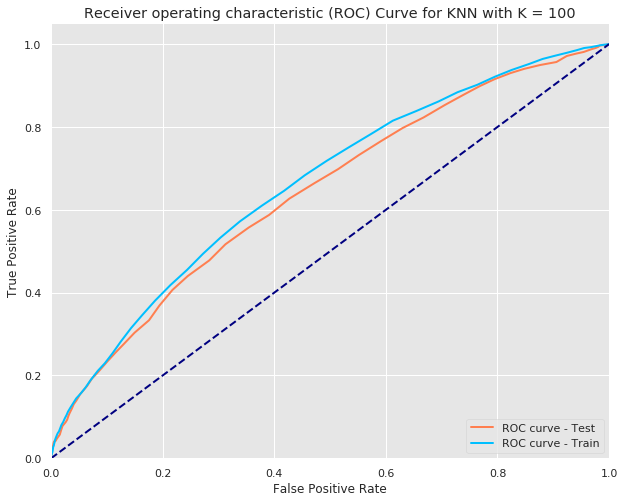

In [128]:
create_roc_auc(knn_best, 'KNN with K = 100')

## Random Forest Classifier

> After GridSearch, parameters used are:
- criterion = 'entropy'
- max_depth = 10
- n_estimators = 100
- min_sample_split = 2 (Default)

> Beside the 6 principal components, the most important features with Random Forest include:
- Number of inpatient visits of the patient in the year preceding the encounter
- Discharge disposition code # 22 : Discharged/transferred to another rehab fac including rehab units of a hospital
- Number of emergency visits of the patient within the year preceding the encounter
- Number of lab tests performed during the encounter
- Time in hospital (measured in days)
- Number of procedures (Number of procedures (other than lab tests) performed during the encounter)
- Discharge disposition code # 3 : Discharged/transferred to SNF (skilled nursing facility)

In [129]:
# Grid Search
param_grid_rf = {'criterion' : ['gini','entropy'],
                 'max_depth': [5,10],
                 'n_estimators': [100, 115, 150]}

In [130]:
# Instantiating Random Forest classifier 
forest = RandomForestClassifier()
grid_rf = GridSearchCV(forest, param_grid = param_grid_rf) # default cv = 3
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10], 'n_estimators': [100, 115, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [131]:
grid_rf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 115}

In [133]:
best_rf = RandomForestClassifier(criterion = 'entropy', max_depth = 10, n_estimators = 115)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [172]:
# Predicting values 

y_train_hat = best_rf.predict(X_train)
y_test_hat = best_rf.predict(X_test) 

In [173]:
print('accuracy train score:', accuracy_score(y_train, y_train_hat))
print('accuracy test score:', accuracy_score(y_test, y_test_hat))
print('recall score for test:', recall_score(y_test, y_test_hat)) 
print('recall score for train:', recall_score(y_train, y_train_hat))
print('precision score for test:', precision_score(y_test, y_test_hat))
print('precision score for train:', precision_score(y_train, y_train_hat))

accuracy train score: 0.6921578178275695
accuracy test score: 0.6122747199220653
recall score for test: 0.532265890344493
recall score for train: 0.6129936616284739
precision score for test: 0.6359420289855072
precision score for train: 0.7277858176555716


In [143]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(18,27))
    plt.barh(range(n_features), model.feature_importances_, align='center', color = 'deepskyblue') 
    plt.yticks(np.arange(n_features), list(X.columns)) 
    plt.xlabel("Feature importance", fontsize=18)
    plt.ylabel("Feature", fontsize=18)
    plt.title('Feature importance of optimized Random Forest Classifier', fontsize=22)

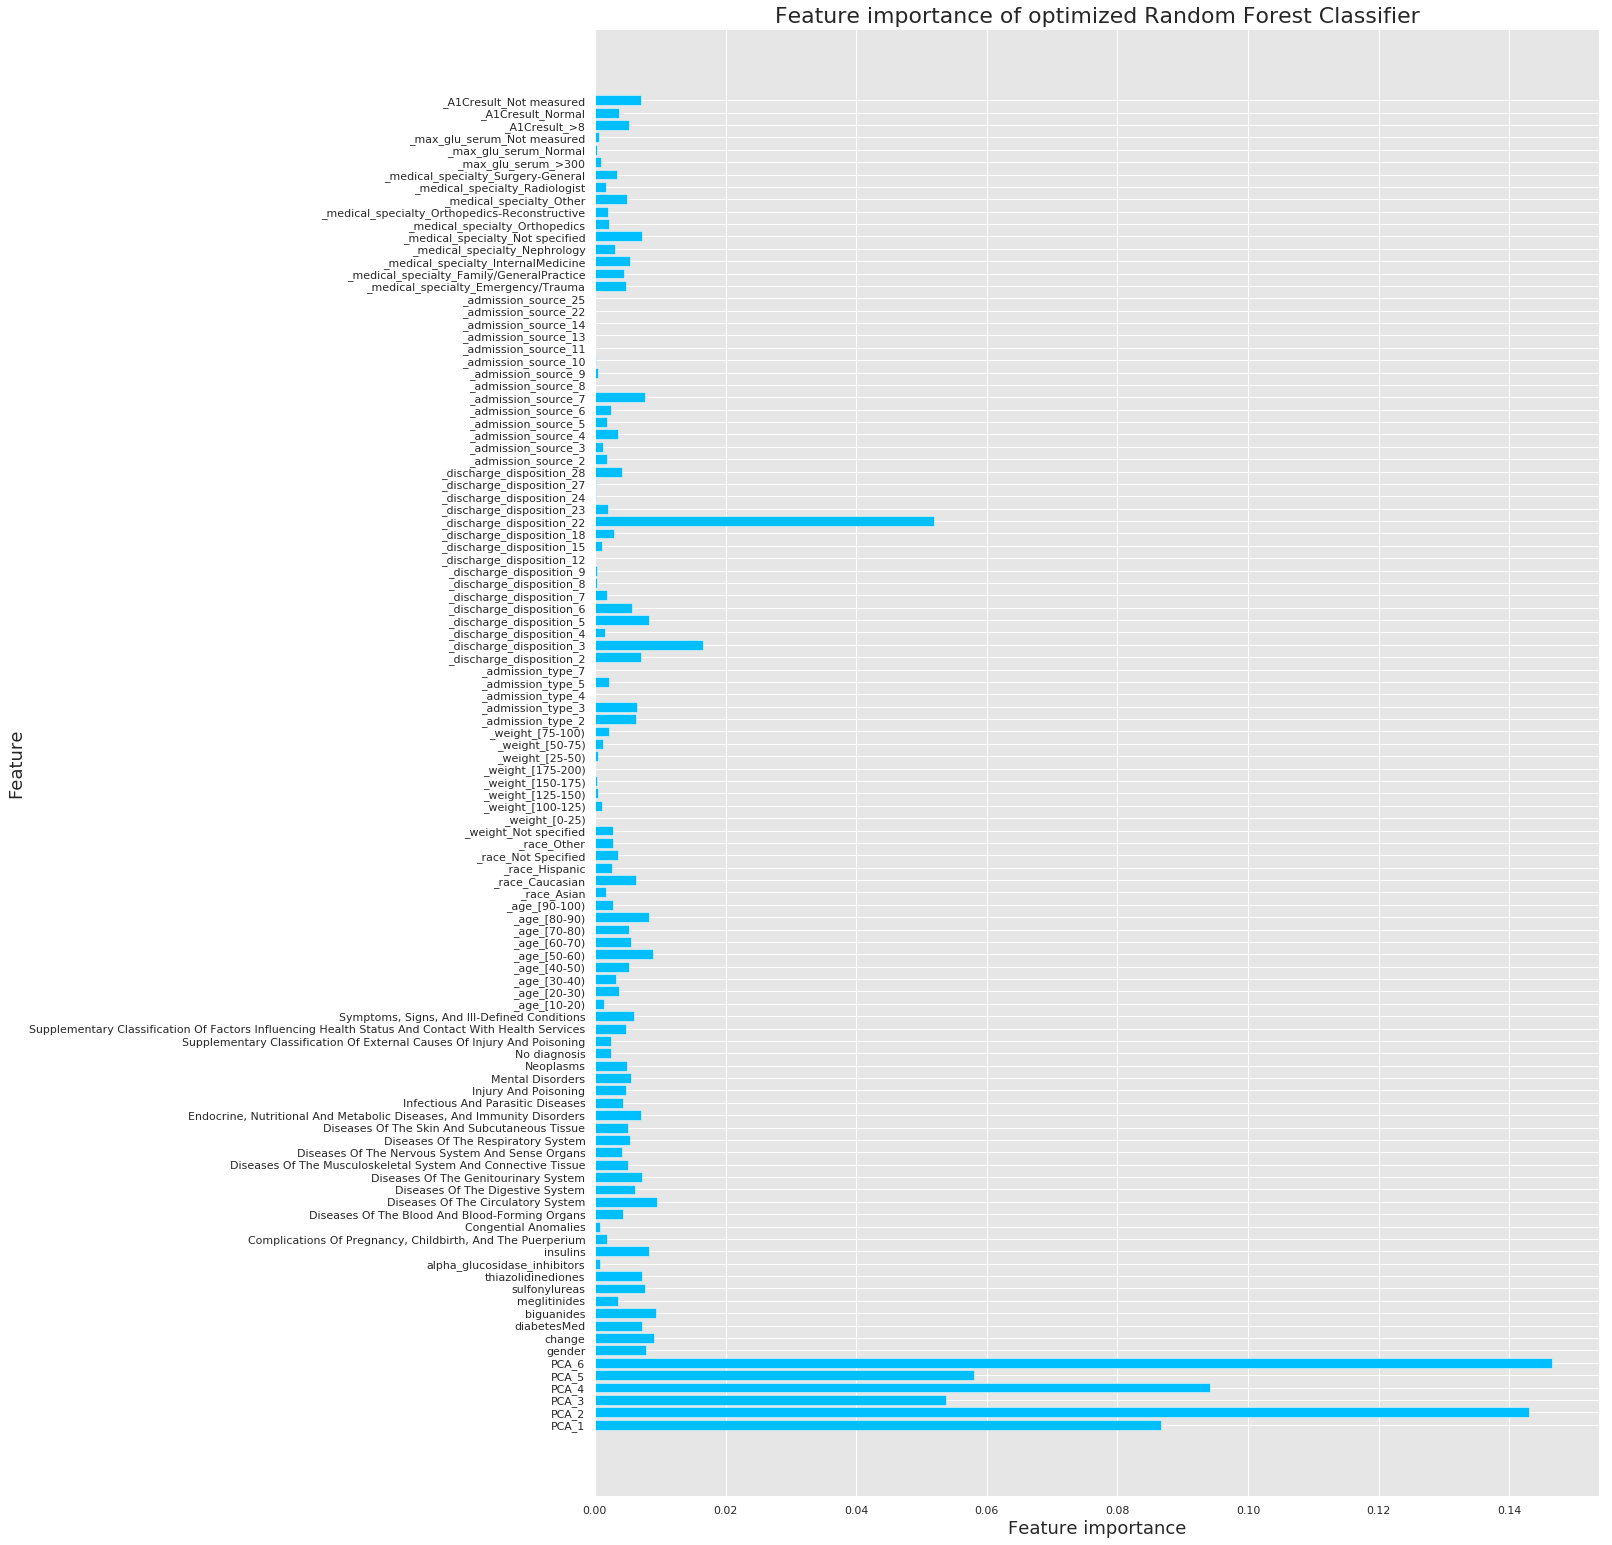

In [144]:
# Plot feature importance

plot_feature_importances(best_rf)

In [92]:
# Confusion Matrix
print(confusion_matrix(y_test, y_test_hat))

# Classification Report for Training data
class_rep_rf = pd.DataFrame(classification_report(y_train, y_train_hat, output_dict = True))
class_rep_rf.rename({'0' : 'y_train', '1' : 'y_train_hat'}, axis = 1, inplace = True)
class_rep_rf

[[1430  615]
 [ 974 1087]]


,y_train,y_train_hat,micro avg,macro avg,weighted avg
f1-score,0.714527,0.663394,0.691062,0.688960,0.688985
precision,0.664643,0.727802,0.691062,0.696223,0.696192
recall,0.772506,0.609459,0.691062,0.690982,0.691062
support,8220.000000,8204.000000,16424.000000,16424.000000,16424.000000


In [93]:
# Classification Report for Testing data

class_rep_rf = pd.DataFrame(classification_report(y_test, y_test_hat, output_dict = True))
class_rep_rf

,0,1,micro avg,macro avg,weighted avg
f1-score,0.642841,0.577731,0.613005,0.610286,0.610159
precision,0.594842,0.638660,0.613005,0.616751,0.616837
recall,0.699267,0.527414,0.613005,0.613340,0.613005
support,2045.000000,2061.000000,4106.000000,4106.000000,4106.000000


In [145]:
print("Training Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_train, y_train_hat) * 100))
print("Test Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, y_test_hat) * 100))

Training Accuracy for Random Forest Classifier: 69.22%
Test Accuracy for Random Forest Classifier: 61.23%


AUC_test: 0.6575183077505282
AUC_train: 0.76929553976993


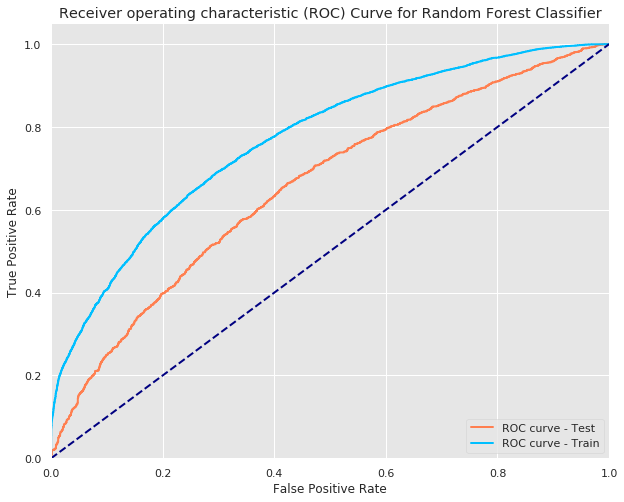

In [146]:
create_roc_auc(best_rf, 'Random Forest Classifier')

## Boosted Trees with XG Boost

In [150]:
clf = xgb.XGBClassifier()

In [151]:
#Minimum loss reduction required to make a further partition on a leaf node of the tree.

param_grid_rf = {'max_depth': [3],
                 'learning_rate' : [0.16],
                 'gamma' : [7], 
                 'n_estimators': [100]}

In [152]:
xg_grid = GridSearchCV(clf, param_grid=param_grid_rf, verbose= 10)

In [153]:
xg_fit = xg_grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=7, learning_rate=0.16, max_depth=3, n_estimators=100 ......


/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV]  gamma=7, learning_rate=0.16, max_depth=3, n_estimators=100, score=0.606027397260274, total=   5.4s
[CV] gamma=7, learning_rate=0.16, max_depth=3, n_estimators=100 ......


/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s


[CV]  gamma=7, learning_rate=0.16, max_depth=3, n_estimators=100, score=0.6065753424657534, total=   5.4s
[CV] gamma=7, learning_rate=0.16, max_depth=3, n_estimators=100 ......


/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.3s finished


[CV]  gamma=7, learning_rate=0.16, max_depth=3, n_estimators=100, score=0.6141761052246986, total=   5.4s


In [174]:
y_train_hat = xg_grid.predict(X_train)
y_test_hat = xg_grid.predict(X_test)

/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/pacman/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [175]:
print('accuracy train score:', accuracy_score(y_train, y_train_hat))
print('accuracy test score:', accuracy_score(y_test, y_test_hat))
print('recall score for test:', recall_score(y_test, y_test_hat)) 
print('recall score for train:', recall_score(y_train, y_train_hat))
print('precision score for test:', precision_score(y_test, y_test_hat))
print('precision score for train:', precision_score(y_train, y_train_hat))

accuracy train score: 0.6314539698002922
accuracy test score: 0.6147101802240623
recall score for test: 0.5482775351770985
recall score for train: 0.568503169185763
precision score for test: 0.6344750140370579
precision score for train: 0.6498536993172634


In [156]:
print("Training Accuracy for XG Boost Classifier: {:.4}%".format(accuracy_score(y_train, y_train_hat) * 100))
print("Test Accuracy for XG Boost Classifier: {:.4}%".format(accuracy_score(y_test, y_test_hat) * 100))

Training Accuracy for XG Boost Classifier: 63.15%
Test Accuracy for XG Boost Classifier: 61.47%


In [157]:
xg_grid.best_params_

{'gamma': 7, 'learning_rate': 0.16, 'max_depth': 3, 'n_estimators': 100}

AUC_test: 0.653918564468313
AUC_train: 0.6831183396978033


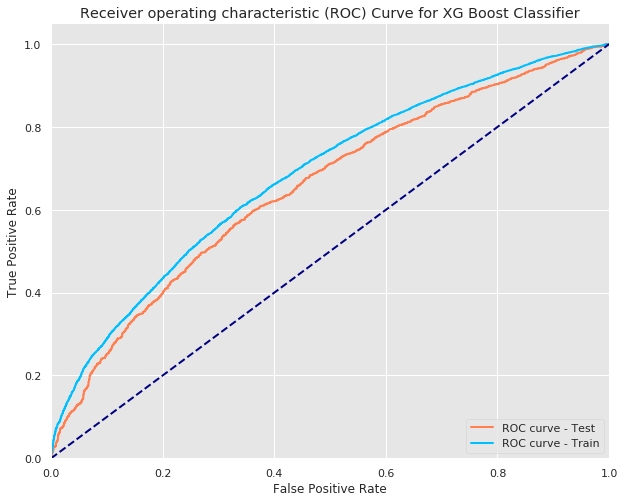

In [158]:
create_roc_auc(xg_fit, 'XG Boost Classifier')

## SGD - Stochastic gradient descent

In [176]:
sgd = SGDClassifier(loss = 'modified_huber',penalty="l1", max_iter=600)
sgd.fit(X_train, y_train) 

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', max_iter=600,
       n_iter=None, n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [177]:
y_train_hat = sgd.predict(X_train)
y_test_hat = sgd.predict(X_test)

In [179]:
print('accuracy train score:', accuracy_score(y_train, y_train_hat))
print('accuracy test score:', accuracy_score(y_test, y_test_hat))
print('recall score for test:', recall_score(y_test, y_test_hat)) 
print('recall score for train:', recall_score(y_train, y_train_hat))
print('precision score for test:', precision_score(y_test, y_test_hat))
print('precision score for train:', precision_score(y_train, y_train_hat))

accuracy train score: 0.6155625913297613
accuracy test score: 0.6078908913784705
recall score for test: 0.5143134400776322
recall score for train: 0.5199902486591906
precision score for test: 0.6351108448172559
precision score for train: 0.6422764227642277


AUC_test: 0.6460351693874719
AUC_train: 0.6570682837047028


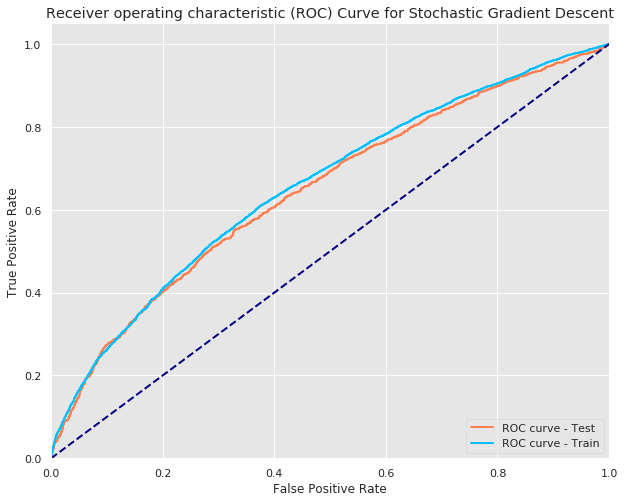

In [180]:
create_roc_auc(sgd, 'Stochastic Gradient Descent')

# Results and Model comparison

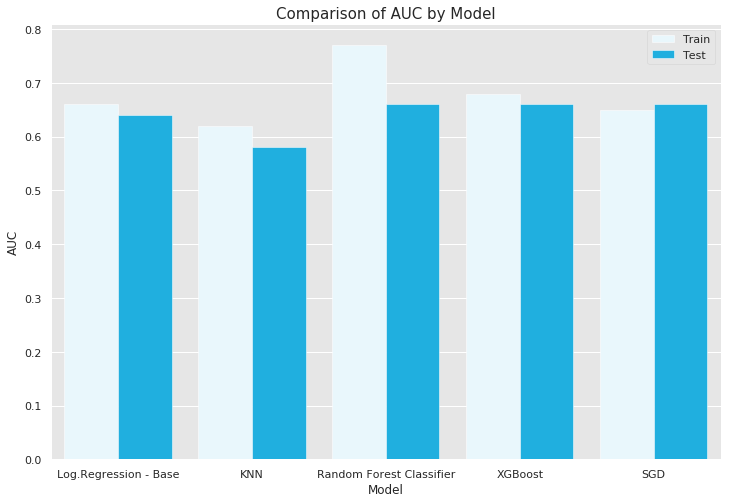

In [181]:
auc_dict = {'Model': ['Log.Regression - Base','Log.Regression - Base',
                      'KNN','KNN',
                      'Random Forest Classifier','Random Forest Classifier',
                      'XGBoost','XGBoost','SGD','SGD'], 
            'AUC': [0.66,0.64,0.62,0.58,0.77,0.66,0.68,0.66, 0.65,0.66],
            'type':['Train','Test','Train','Test','Train','Test','Train','Test','Train','Test']}

# Bar plot
plt.figure(figsize=(12,8))
auc_scores = pd.DataFrame(auc_dict, columns = auc_dict.keys())
ax = sns.barplot(x="Model", y="AUC", hue="type", data=auc_scores, color='deepskyblue')
plt.title('Comparison of AUC by Model',fontsize = 15)
plt.legend(loc="upper right")

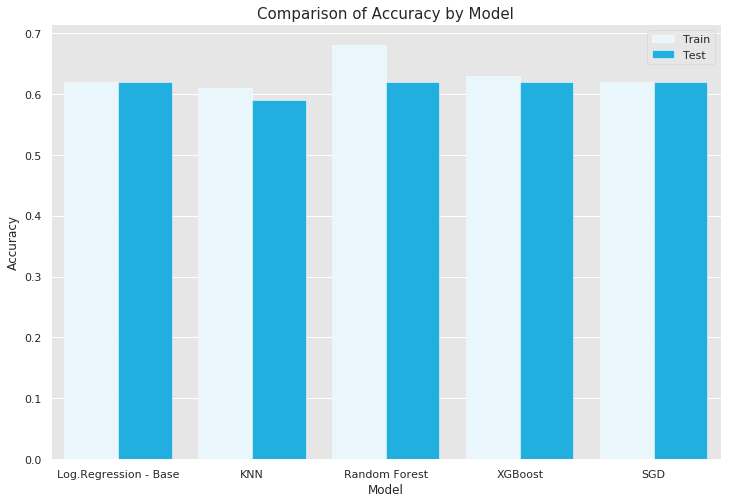

In [182]:
accuracy_dict = {'Model': ['Log.Regression - Base','Log.Regression - Base','KNN','KNN','Random Forest','Random Forest',
                      'XGBoost','XGBoost', 'SGD' , 'SGD'], 
            'Accuracy': [0.62,0.62,0.61,0.59,0.68,0.62,0.63,0.62,0.62,0.62],
            'type': ['Train','Test','Train','Test','Train','Test','Train','Test','Train','Test']}

# Bar plot
plt.figure(figsize=(12,8))
accu_scores = pd.DataFrame(accuracy_dict, columns = accuracy_dict.keys())
ax = sns.barplot(x="Model", y="Accuracy", hue="type", data=accu_scores, color='deepskyblue')
plt.title('Comparison of Accuracy by Model',fontsize = 15)
plt.legend(loc="upper right")


We chose recall (or sensitivity) as the most important metric for our classification problem. We want to identify as many patients who are at risk of being readmitted within 30 days, even if it puts us at risk of misidentify patients who won't be readmitted in reality. We want the model to be sensitive and capture as many patients as possible who are at risk of being readmitted within 30 days. That being said, we are fully aware that our optimized models can  return many "false positives", meaning that they are more likely to have a higher Type 1 Error.

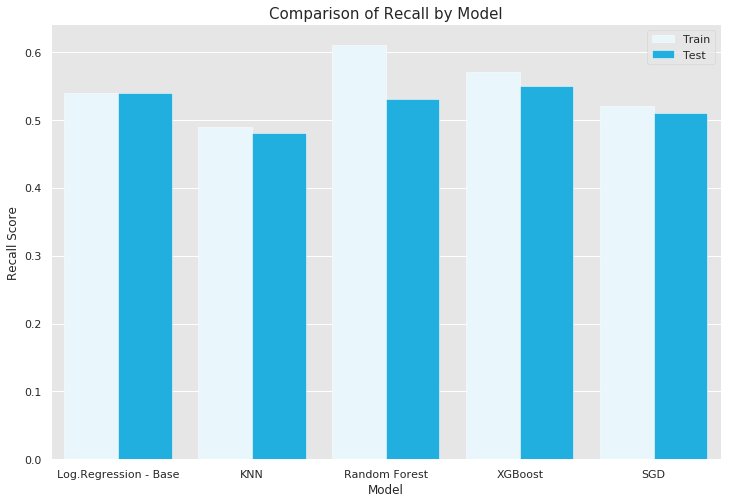

In [185]:
recall_dict = {'Model': ['Log.Regression - Base','Log.Regression - Base','KNN','KNN','Random Forest','Random Forest',
                      'XGBoost','XGBoost', 'SGD' , 'SGD'], 
            'Recall Score': [0.54,0.54,0.49,0.48,0.61,0.53,0.57,0.55,0.52,0.51],
            'type': ['Train','Test','Train','Test','Train','Test','Train','Test','Train','Test']}

# Bar plot
plt.figure(figsize=(12,8))
recall_scores = pd.DataFrame(recall_dict, columns = recall_dict.keys())
ax = sns.barplot(x="Model", y="Recall Score", hue="type", data=recall_scores, color='deepskyblue')
plt.title('Comparison of Recall by Model',fontsize = 15)
plt.legend(loc="upper right")


# Conclusion & Next Steps

For our Classifier we considered the most important evaluation metric to be recall.
In order to help hospital administration effectively address the issue of Hospital Readmissions <30 days we want our model to be able to correctly predict as many of the relevant cases as possible. 
No real surprise that the number of previous inpatient visits proved to be the strongest predictor of readmission within 30 days. 
Another strong predictor were discharge dispositions #22 and # 3, which correspond to discharge to a rehab facility or skilled nursing facility, respectively.
Patients who were on medications that fell into the ‘biguanides’ group showed a propensity to readmission.


**Model improvements:** 
- Feature Engineering
- Other models such as Support Vector Machine
- Multiclass with three possible classes (<30, >30, No)

**Recommendations:**
The most important indicator of readmission is the number of previous inpatient admissions, which could speak to the idea that an individual’s lifestyle choices and not simply their ailments must be addressed before and after release. 
Releasing a patient for continued treatment and rehabilitation might seem proactive and safe, however our data shows that discharge to these facilities prove to have no positive impact on overall health improvement.
A final thought was that the number of lab procedures proved to be more predictive than the number of diagnoses when identifying a patient who was going to be readmitted. This could be because lab procedures indicate a complicated diagnoses, but it also highlights the inefficient and expensive approach healthcare facilities take when treating patients. 
